In [52]:
#Libraries
import shapely
import networkx as nx
import json
import community
import pdb
import numpy as np
from scipy.spatial import distance
from community import best_partition
import matplotlib.pyplot as plt
# import ipdb 是一种调试工具
from sklearn import cluster,metrics
from mpl_toolkits.mplot3d import Axes3D
#embed pictures into html
%matplotlib inline 

# Example data set: one design scenario. Each design scenario contains 47 buildings
with open('../data/geometry/2.json') as f:
    data = json.load(f)
total = []

In [53]:
# Project shapes onto 2D. Each buildings will be polygons
from shapely.geometry import Polygon
polygon_alles = []
for i,feature in enumerate(data['features']):
    if (i > 0):
		#for each cube, find the collections of all 8 points
        convexs = set()
        centroid = []

        for surfaces in feature['geometry']['coordinates']:
           
            surface = surfaces[0][0:4]
            surface_2d = ((x[0],x[1]) for x in surface)
            for p in surface_2d:
                convexs.add(p)
        convexs_2d = list(convexs)
        polygon = Polygon(convexs_2d)
        polygon_alles.append(polygon)

In [54]:
# compute centroid of each building
for i,feature in enumerate(data['features']):
	if (i > 0):
		#for each cube, find the collections of all 8 points
		convexs = set()
		centroid = []

		for surfaces in feature['geometry']['coordinates']:
			surface = surfaces[0][0:4]
			for p in surface:
				convexs.add(tuple(p))
		convexs = list(convexs)
		centroid = [sum([x[0] for x in convexs])/8.0,sum([x[1] for x in convexs])/8.0,sum([x[2] for x in convexs])/8.0]
		total.append(centroid)
# X contains centroids of all the 47 buildings
X = np.matrix(total) #transform into npmatrix for better processing. X shape is (47,3)

In [55]:
adj_poly = np.zeros((47,47))
for c,c_poly in enumerate(polygon_alles):
    for a,a_poly in enumerate(polygon_alles):
        adj_poly[c,a] = c_poly.distance(a_poly)
print(adj_poly)

[[     0.          10352.37046383  19135.4944655  ...,  38383.45258937
   35033.96376796      0.        ]
 [ 10352.37046383      0.          33634.97370935 ...,  40188.48031917
   34797.5153399    6562.75131606]
 [ 19135.4944655   33634.97370935      0.         ...,  24211.8500254
   25721.85322363  21981.07245707]
 ..., 
 [ 38383.45258937  40188.48031917  24211.8500254  ...,      0.
    4342.8079853   33791.75250195]
 [ 35033.96376796  34797.5153399   25721.85322363 ...,   4342.8079853
       0.          29818.79455955]
 [     0.           6562.75131606  21981.07245707 ...,  33791.75250195
   29818.79455955      0.        ]]


In [56]:
# compute pairwise distance(d2/angle) of 47 * 47 
Y = distance.pdist(X,'euclidean')# pairwise distance 平直的
Z = distance.cdist(X,X,'euclidean')# 47 by 47  

#2D matrix
X_2D = X[:,0:2]
Y_2D = distance.pdist(X_2D,'euclidean')# pairwise distance 平直的
Z_2D = distance.cdist(X_2D,X_2D,'euclidean')# 47 by 47  

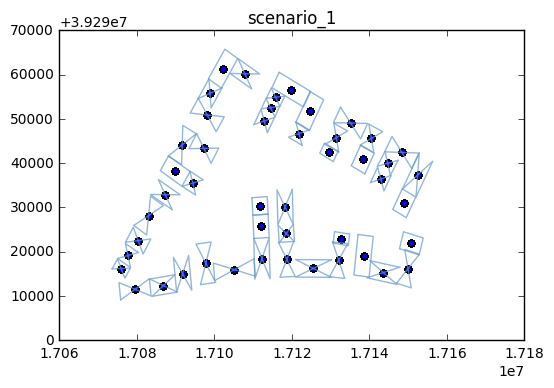

In [57]:
from descartes import PolygonPatch
fig = plt.figure()
ax = fig.add_subplot(111)
for i,poly in enumerate(polygon_alles):
    x,y = poly.exterior.xy
    ax.plot(x, y, color='#6699cc', alpha=0.7,
    linewidth=1, solid_capstyle='round', zorder=2)
    ax.scatter(X[:,0],X[:,1],c='b')


ax.set_title('scenario_1')

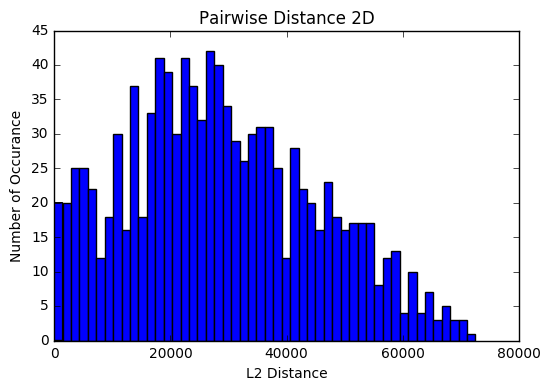

In [58]:
pw_dis = list(adj_poly[np.triu_indices(47)])
pw = [y for y in pw_dis if y != 0.0]

fig = plt.figure()
a=fig.add_subplot(1,1,1)
a.set_title("Pairwise Distance 2D")
plt.xlabel("L2 Distance")
plt.ylabel("Number of Occurance")
plt.hist(pw,bins=50)
# hist, binedge = np.histogram(Y,bins=50)
plt.locator_params(axis = 'x', nbins = 4)

[0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 1 0 0 0 0 1 0]
0.0195675297164


/usr/local/lib/python3.5/site-packages/matplotlib/lines.py:1145: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


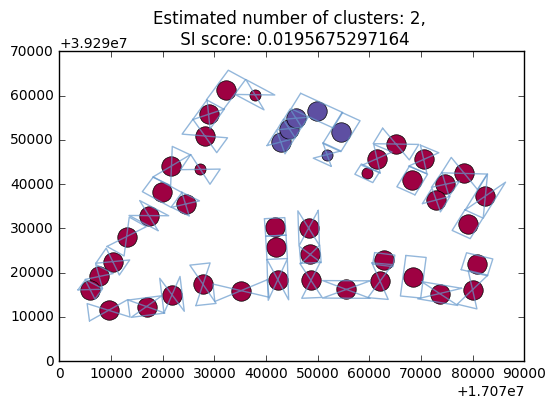

[[ 17121799.86272874  39336680.44103879]]


In [62]:
max_distance = np.percentile(pw,4)
dbscan = cluster.DBSCAN(eps=max_distance,min_samples=3,metric='precomputed')
labels = dbscan.fit_predict(adj_poly)
print(labels)
SI_score = metrics.silhouette_score(adj_poly,labels)
print(SI_score)

core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = X_2D[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)

    xy = X_2D[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=8)

for i,poly in enumerate(polygon_alles):
    x,y = poly.exterior.xy
    plt.plot(x, y, color='#6699cc', alpha=0.7,
    linewidth=1, solid_capstyle='round', zorder=2)
    
plt.title('Estimated number of clusters: %d, \n SI score: %s' % (n_clusters_,SI_score))
plt.show()
print(xy)